In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

!gdown https://drive.google.com/uc?id=1JkCpzOk8qqakxUW-phQi6JeAah_mIn90


# Definir rutas
zip_path = '/content/split_data608.zip'
extract_path = '/content'

# Crear carpeta de destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Archivo descomprimido en:", extract_path)

Mounted at /content/drive
Downloading...
From (original): https://drive.google.com/uc?id=1JkCpzOk8qqakxUW-phQi6JeAah_mIn90
From (redirected): https://drive.google.com/uc?id=1JkCpzOk8qqakxUW-phQi6JeAah_mIn90&confirm=t&uuid=f8a3eb8a-c997-4d96-959c-1ae78a93dd47
To: /content/split_data608.zip
100% 1.48G/1.48G [00:16<00:00, 92.2MB/s]
Archivo descomprimido en: /content


In [ ]:
!pip install lightning --quiet
!pip install torchviz --quiet
!pip install hiddenlayer --quiet
!pip install onnx --quiet
!pip install lpips --quiet
!pip install scikit-image lpips
!pip install wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
import torch, numpy as np, pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips

# 1) IMPORTA tu clase si ya la tienes definida en otro archivo.
# from tu_modulo import UNet_SuperResolution

# --- Si no, aquí tienes una versión esquemática compatible con tu print ---

import torch
import torch.nn as nn

class UNet_SuperResolution(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512, 1024, 2048], dropout_rate=0.1, n_groups=8):
        super().__init__()
        act = nn.SiLU

        def block(in_f, out_f):
            return nn.Sequential(
                nn.Conv2d(in_f, out_f, 3, padding=1),
                nn.GroupNorm(num_groups=min(n_groups, out_f), num_channels=out_f),
                act(),
                nn.Conv2d(out_f, out_f, 3, padding=1),
                nn.GroupNorm(num_groups=min(n_groups, out_f), num_channels=out_f),
                act(),
                nn.Dropout(dropout_rate)
            )

        # Encoder
        self.enc1 = block(in_channels, features[0])
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = block(features[0], features[1])
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = block(features[1], features[2])
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = block(features[2], features[3])
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = block(features[3], features[4])

        self.up1 = nn.ConvTranspose2d(features[4], features[3], 2, stride=2)
        self.dec1 = block(features[4], features[3])
        self.up2 = nn.ConvTranspose2d(features[3], features[2], 2, stride=2)
        self.dec2 = block(features[3], features[2])
        self.up3 = nn.ConvTranspose2d(features[2], features[1], 2, stride=2)
        self.dec3 = block(features[2], features[1])
        self.up4 = nn.ConvTranspose2d(features[1], features[0], 2, stride=2)
        self.dec4 = block(features[1], features[0])
        self.final = nn.Sequential(nn.Conv2d(features[0], out_channels, 1),nn.Tanh())

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        b = self.bottleneck(p4)
        up1 = self.up1(b)
        cat1 = torch.cat([up1, e4], dim=1)
        d1 = self.dec1(cat1)
        up2 = self.up2(d1)
        cat2 = torch.cat([up2, e3], dim=1)
        d2 = self.dec2(cat2)
        up3 = self.up3(d2)
        cat3 = torch.cat([up3, e2], dim=1)
        d3 = self.dec3(cat3)
        up4 = self.up4(d3)
        cat4 = torch.cat([up4, e1], dim=1)
        d4 = self.dec4(cat4)
        out = self.final(d4)
        return out







In [ ]:
# 2) Cargar checkpoint y reconstruir con MISMA config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = "/content/drive/MyDrive/202425_Q2_ID20.2_SRGalaxy_102_Mariana_Miguel_Jorge/super-resolucion-galaxias/Model/superres_final_checkpoint.pth"
ckpt = torch.load(save_path, map_location=device)
cfg  = ckpt['model_config']

feat_cfg = cfg.get('features', [64,128,256,512,1024,2048])
features = feat_cfg[:5] # tu print muestra hasta 1024 en bottleneck
model = UNet_SuperResolution(
    in_channels=cfg.get('in_channels', 1),
    out_channels=cfg.get('out_channels', 1),
    features=features,
    n_groups=cfg.get('n_groups', 8),
    dropout_rate=cfg.get('dropout_rate', 0.2)
).to(device)

state = ckpt['model_state_dict']
if next(iter(state)).startswith('module.'):
    state = {k.replace('module.', '', 1): v for k,v in state.items()}
model.load_state_dict(state, strict=True)
model.eval()


UNet_SuperResolution(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (2): SiLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    (5): SiLU()
    (6): Dropout(p=0.2, inplace=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(8, 128, eps=1e-05, affine=True)
    (2): SiLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GroupNorm(8, 128, eps=1e-05, affine=True)
    (5): SiLU()
    (6): Dropout(p=0.2, inplace=False)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): 

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import os

class PrepareDataset(Dataset):
    def __init__(self, dud_dir, acs_dir, max_items=None, target_size=(608, 608)):
        self.dud_paths = sorted(os.listdir(dud_dir))
        self.acs_paths = sorted(os.listdir(acs_dir))
        if max_items:
            self.dud_paths = self.dud_paths[:max_items]
            self.acs_paths = self.acs_paths[:max_items]
        self.dud_dir = dud_dir
        self.acs_dir = acs_dir
        self.target_size = target_size
        self.transform = T.ToTensor()

    def __len__(self):
        return len(self.dud_paths)

    def __getitem__(self, idx):
        dud_path = os.path.join(self.dud_dir, self.dud_paths[idx])
        acs_path = os.path.join(self.acs_dir, self.acs_paths[idx])
        dud = Image.open(dud_path).convert("L")
        acs = Image.open(acs_path).convert("L")
        dud = dud.resize(self.target_size, Image.BICUBIC)
        return self.transform(dud), self.transform(acs)


In [ ]:
train_dataset = PrepareDataset(
    dud_dir='/content/split_data/train/dud',
    acs_dir='/content/split_data/train/acs',
    max_items=103129
)
val_dataset = PrepareDataset(
    dud_dir='/content/split_data/val/dud',
    acs_dir='/content/split_data/val/acs',
    max_items=12891
)
test_dataset = PrepareDataset(
    dud_dir='/content/split_data/test/dud',
    acs_dir='/content/split_data/test/acs',
    max_items=12892
)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=8)
test_loader  = DataLoader(test_dataset,  batch_size=8)


In [ ]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips

model.eval()
lpips_fn = lpips.LPIPS(net='vgg').to(device)

psnr_test, ssim_test, lpips_test = [], [], []
invalid_count = 0

with torch.no_grad():
    for dud_up, acs in test_loader:
        dud_up, acs = dud_up.to(device), acs.to(device)
        output = model(dud_up)

        for i in range(output.shape[0]):
            pred = output[i].detach().cpu().numpy().squeeze()
            gt = acs[i].detach().cpu().numpy().squeeze()
            pred_img = np.clip(pred, 0, 1)
            gt_img = np.clip(gt, 0, 1)

            this_psnr = psnr(gt_img, pred_img, data_range=1)
            this_ssim = ssim(gt_img, pred_img, data_range=1)


            pred_lpips = torch.tensor(pred_img).unsqueeze(0).unsqueeze(0) * 2 - 1
            gt_lpips = torch.tensor(gt_img).unsqueeze(0).unsqueeze(0) * 2 - 1
            pred_lpips = pred_lpips.to(device).float()
            gt_lpips = gt_lpips.to(device).float()
            this_lpips = lpips_fn(pred_lpips, gt_lpips).item()


            if np.isfinite(this_psnr) and np.isfinite(this_ssim) and np.isfinite(this_lpips):
                psnr_test.append(this_psnr)
                ssim_test.append(this_ssim)
                lpips_test.append(this_lpips)
            else:
                invalid_count += 1

print(f"PSNR promedio: {np.mean(psnr_test):.2f}")
print(f"SSIM promedio: {np.mean(ssim_test):.4f}")
print(f"LPIPS promedio): {np.mean(lpips_test):.4f}")

print(f"Número de casos inválidos: {invalid_count}")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
PSNR promedio: 44.22
SSIM promedio: 0.9509
LPIPS promedio): 0.0178
Número de casos inválidos: 0


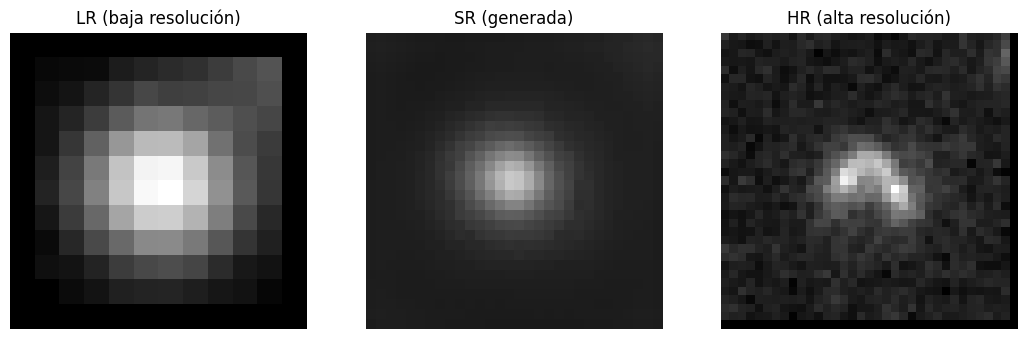

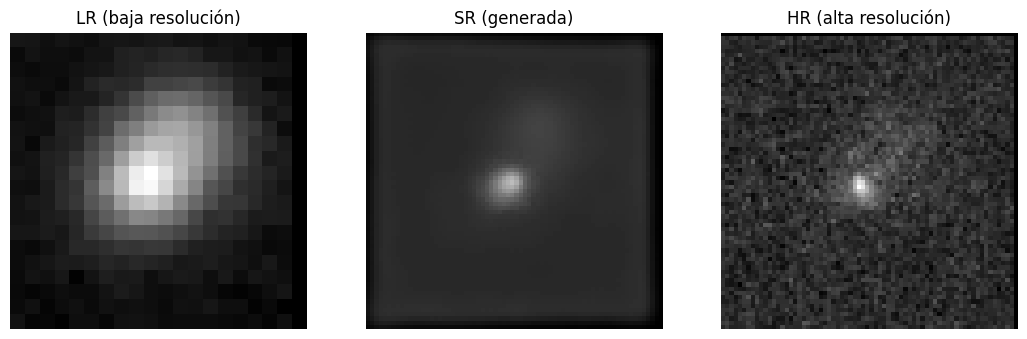

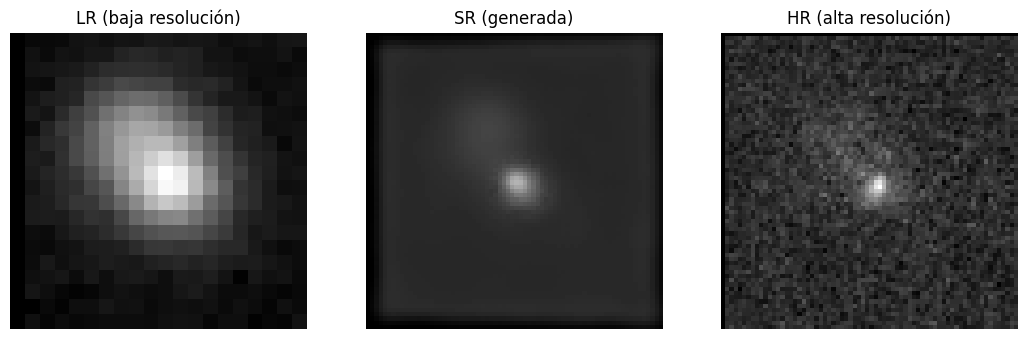

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

dud_dir = '/content/split_data/test/dud'
acs_dir = '/content/split_data/test/acs'

model.eval()

filenames_to_show = [
    "n10_0_87915.png",
    "n10_103_112779_aug1_rot90.png",
    "n10_103_112779_aug7_fliplr_rot90.png",
]

# Para cada imagen, los tamaños de crop: (LR_crop, SR_crop, HR_crop)
# (height, width) por cada versión
custom_crops = {
    "n10_0_87915.png":       ((12, 12), (30, 30), (35, 35)),
    "n10_103_112779_aug1_rot90.png": ((20, 20), (70, 70), (70, 70)),  # Ejemplo: mismos tamaños
    "n10_103_112779_aug7_fliplr_rot90.png": ((20, 20), (70, 70), (70, 70)),
}

def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2
    return img[starty:starty+cropy, startx:startx+cropx]

for filename in filenames_to_show:
    dud_path = os.path.join(dud_dir, filename)
    acs_path = os.path.join(acs_dir, filename)

    if not os.path.exists(dud_path) or not os.path.exists(acs_path):
        print(f"⚠️ No se encontró {filename}")
        continue

    # ABRIR imágenes originales
    dud_img = Image.open(dud_path).convert("L")
    acs_img = Image.open(acs_path).convert("L")

    # RESIZE para el modelo
    dud_img_resized = dud_img.resize((608, 608), Image.BICUBIC)
    dud_tensor = torch.from_numpy(np.array(dud_img_resized)).unsqueeze(0).unsqueeze(0).float() / 255.0
    dud_tensor = dud_tensor.to(next(model.parameters()).device)

    with torch.no_grad():
        pred_tensor = model(dud_tensor)
        pred_img = pred_tensor.squeeze().cpu().numpy()

    # Convertir originales a numpy [0,1]
    dud_np = np.array(dud_img) / 255.0
    acs_np = np.array(acs_img) / 255.0

    # Crops centrados de diferentes tamaños
    lr_crop, sr_crop, hr_crop = custom_crops.get(filename, ((70,70), (70,70), (70,70)))

    dud_crop = crop_center(dud_np, lr_crop[1], lr_crop[0])
    pred_crop = crop_center(pred_img, sr_crop[1], sr_crop[0])
    acs_crop = crop_center(acs_np, hr_crop[1], hr_crop[0])

    # Mostrar
    plt.figure(figsize=(13,5))
    plt.subplot(1,3,1)
    plt.imshow(dud_crop, cmap='gray', vmin=0, vmax=1)
    plt.title(f"LR (baja resolución)")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(pred_crop, cmap='gray', vmin=0, vmax=1)
    plt.title(f"SR (generada)")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(acs_crop, cmap='gray', vmin=0, vmax=1)
    plt.title(f"HR (alta resolución)")
    plt.axis('off')
    plt.show()


In [ ]:
import numpy as np

def stretch_asinh(x, k=0.1):
    """
    Aplica un stretch asinh (parecido a log) a la imagen.
    - x: array [H,W] en [0,1]
    - k: controla cuánto se comprimen los brillos altos
    """
    x = np.clip(x, 0, None)       # quita negativos
    return np.arcsinh(x / k) / np.arcsinh(1.0 / k)  # normaliza a [0,1]


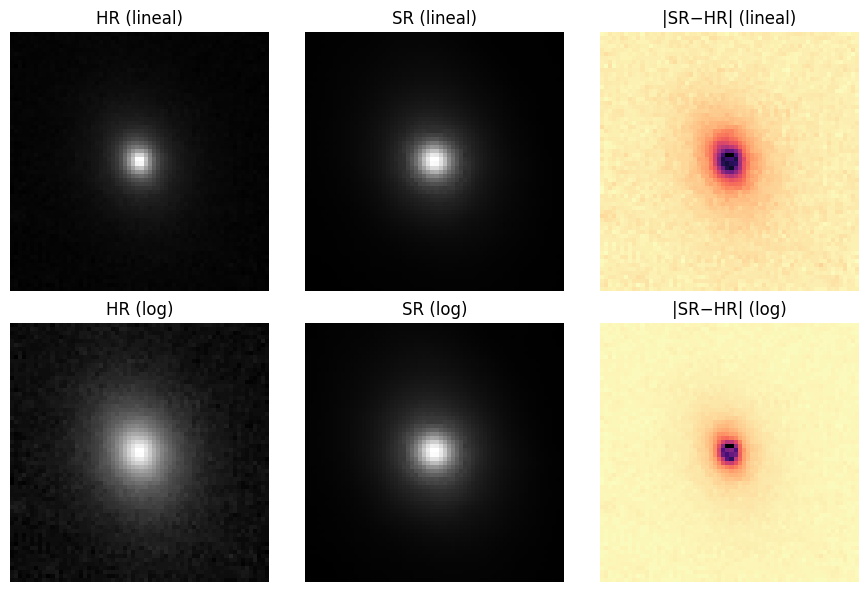

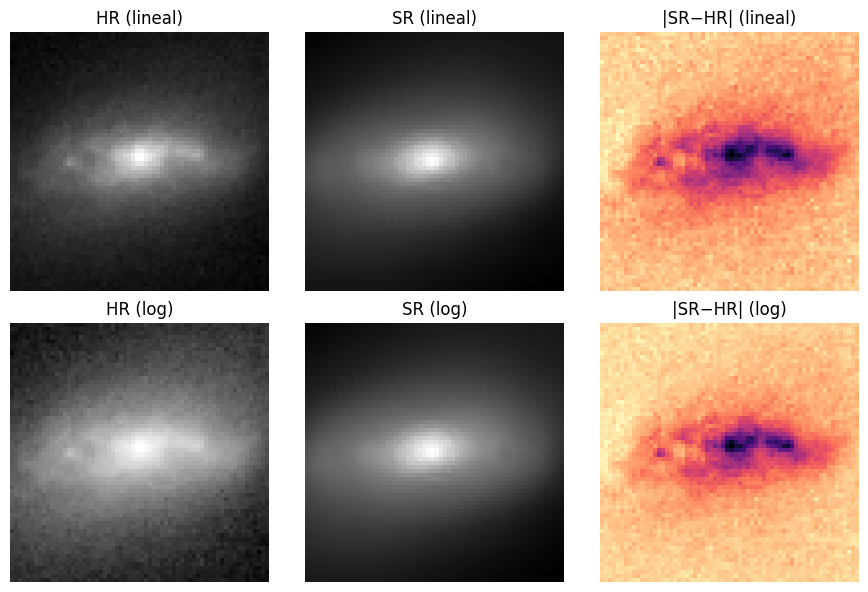

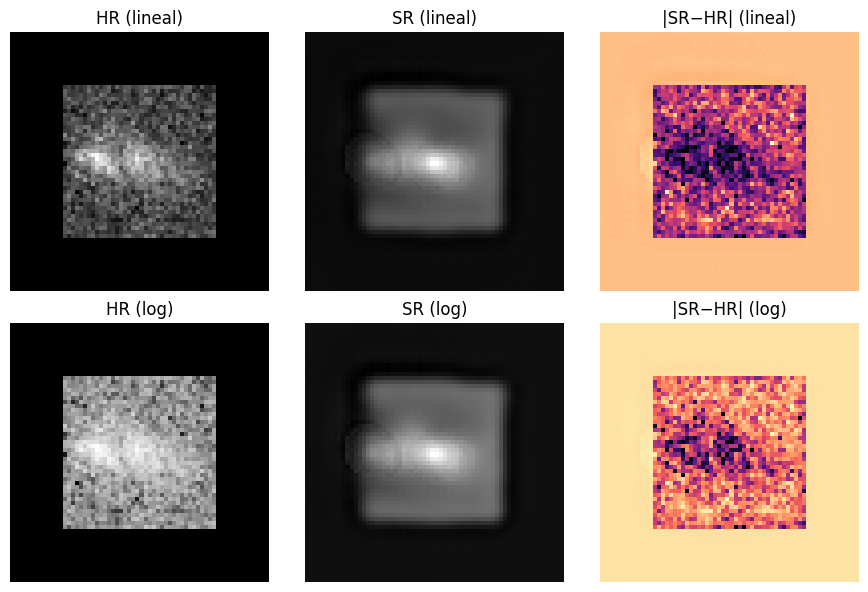

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def crop_center(img, cropx, cropy):
    """Recorta un crop central de tamaño (cropx, cropy)."""
    y, x = img.shape
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2
    return img[starty:starty+cropy, startx:startx+cropx]


n_show = 3
crop_size = (64, 64)


dud_up, acs = next(iter(test_loader))
dud_up = dud_up.to(device)
acs = acs.to(device)

with torch.no_grad():
    out = model(dud_up)
    out_01 = ((out + 1) / 2).clamp(0,1)   # salida [0,1]


idxs = random.sample(range(out_01.shape[0]), min(n_show, out_01.shape[0]))

for i in idxs:
    p = out_01[i].cpu().numpy().squeeze()
    g = acs[i].cpu().numpy().squeeze()
    res = np.abs(p - g)

    cx, cy = crop_size
    p_crop = crop_center(p, cx, cy)
    g_crop = crop_center(g, cx, cy)
    res_crop = crop_center(res, cx, cy)

    fig, axs = plt.subplots(2,3, figsize=(9,6))

    # Fila 1: escala lineal
    axs[0,0].imshow(g_crop, cmap='gray'); axs[0,0].set_title("HR (lineal)"); axs[0,0].axis('off')
    axs[0,1].imshow(p_crop, cmap='gray'); axs[0,1].set_title("SR (lineal)"); axs[0,1].axis('off')
    axs[0,2].imshow(res_crop, cmap='magma'); axs[0,2].set_title("|SR−HR| (lineal)"); axs[0,2].axis('off')

    # Fila 2: escala log/asinh
    axs[1,0].imshow(stretch_asinh(g_crop), cmap='gray'); axs[1,0].set_title("HR (log)"); axs[1,0].axis('off')
    axs[1,1].imshow(stretch_asinh(p_crop), cmap='gray'); axs[1,1].set_title("SR (log)"); axs[1,1].axis('off')
    axs[1,2].imshow(stretch_asinh(res_crop), cmap='magma'); axs[1,2].set_title("|SR−HR| (log)"); axs[1,2].axis('off')

    plt.tight_layout()
    plt.show()
